In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import misc
import numpy as np
import glob
import matplotlib.pyplot as plt
from network import Network
from circle_generator import Circles
from dataset import SegmentationDataset
from loss import SegmentationLoss, ImageLoss
from unet import Unet
import os
from dcgan import NetG
import tqdm

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

In [4]:
def generate_batch(batch_size=40, random_seed=42, z_shape=(3, 64, 64)):
    np.random.seed(random_seed)
    train_images, train_segmentation = predata.get_train_batch(batch_size)
    train_images = Variable(torch.from_numpy(train_images).float().cuda(), 
                            requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(train_segmentation).cuda(), 
                                  requires_grad=False)
    torch.manual_seed(random_seed)
    z_input = Variable(torch.randn(batch_size, z_shape[0], 
                                   z_shape[1], z_shape[2]).cuda(), requires_grad=True)
    return train_images, train_segmentation, z_input

In [5]:
def normalize_z(z):
    norm_z = z.data.norm(dim=1, p=2)
    norm_z = norm_z.unsqueeze(dim=1)
    norm_z = norm_z.repeat(1, int(z.size()[1]), 1, 1)
    norm_z.clamp_(min=1.0)
    z.data = z.data / norm_z

In [6]:
def plot_segmentation(segm, gt_segm, num_epoch):
    segm_numpy = segm.data.cpu().numpy()
    gt_segm_numpy = gt_segm.data.cpu().numpy()
    for i, image in enumerate(segm_numpy):
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(np.argmax(image, 0))
        axarr[0].set_title('Gen segmentation, epoch = {}'.format(num_epoch))
        axarr[1].imshow(gt_segm_numpy[i])
        axarr[1].set_title('Real segmentation')
    plt.show()

In [19]:
def train_generative_unet(net, train_images, train_segmentation, segm_loss, img_loss, without_segmentation, 
                          z_input, lr=0.01, num_epochs=3000, print_history=50):
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=lr)

    loss_epoch = []
    num_epochs = num_epochs
    print_history = print_history

    for epoch in tqdm.tqdm(range(num_epochs)):
        normalize_z(z_input)
        optimizer.zero_grad()   
        img, segm = net(z_input)

        if (epoch + 1) % print_history == 0:
            plot_segmentation(segm[-1:], 
                              train_segmentation[-1:], 
                              epoch)

        loss = segm_loss(segm[:-without_segmentation], 
                         train_segmentation[:-without_segmentation]) + 1000 * img_loss(img, train_images)
        loss_epoch.append(loss.data.cpu()[0])

        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100000 == 0:
            torch.save(net.state_dict(), './model-dcgan-{}'.format(epoch + 1))
        #print('epoch - {}, loss - {}'.format(epoch, loss.data.cpu().numpy()[0]))

    normalize_z(z_input)
    return loss_epoch

In [20]:
def train_baseline_unet(net, train_images, train_segmentation, segm_loss, 
                        lr=0.0005, num_epochs=5000):
    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_epoch = []
    num_epochs = num_epochs

    for epoch in range(num_epochs):
        optimizer.zero_grad()   
        segm = net(train_images)

        loss = segm_loss(segm, train_segmentation)
        loss_epoch.append(loss.data[0])
        loss.backward()
        optimizer.step()
        #print('epoch - {}, loss - {}'.format(epoch, loss.data.cpu().numpy()[0]))

    return loss_epoch

In [21]:
def test(net, test_images, test_segmentation, segm_loss, img_loss=None,
         is_generative=False, z_input=None, lr=0.005, num_epoch=2000):
    if is_generative:
        optimizer = optim.Adam([z_input], lr=lr)
        test_loss = []
        num_epochs = num_epoch

        for epoch in range(num_epochs):
            normalize_z(z_input)
            optimizer.zero_grad()   
            img, segm = net(z_input)
            loss = img_loss(img, test_images)
            test_loss.append(loss.data[0])
            loss.backward()
            optimizer.step()
            #print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

        normalize_z(z_input)
        img, segm = net(z_input)
        show_image_segm(img.data.cpu().numpy(), segm.data.cpu().numpy(), 
                        test_images.data.cpu().numpy(), test_segmentation.data.cpu().numpy())
        return test_loss, segm_loss(segm, test_segmentation).data[0]
    else:
        segm = net(test_images)
        show_image_segm(test_images.data.cpu().numpy(), segm.data.cpu().numpy(), 
                        test_images.data.cpu().numpy(), test_segmentation.data.cpu().numpy())
        return segm_loss(segm, test_segmentation).data[0]

### Generate data

In [13]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)

In [14]:
z_shape=(512, 1, 1)

In [15]:
train_images, train_segmentation, z_input = generate_batch(batch_size=100, random_seed=42, 
                                                           z_shape=z_shape)

In [16]:
test_images, test_segmentation, z_test = generate_batch(batch_size=10, random_seed=1, 
                                                        z_shape=z_shape)

### train baseline

In [13]:
net = Unet(num_z_channels=1, num_classes=3, is_generative=False).cuda()
segm_loss = SegmentationLoss()

In [14]:
loss_baseline = train_baseline_unet(net=net, train_images=train_images[:20], 
                                    train_segmentation=train_segmentation[:20], 
                                    segm_loss=segm_loss, 
                                    num_epochs=40000, lr=0.0005)

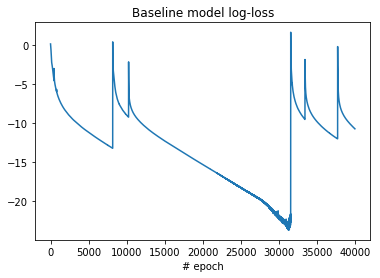

In [15]:
plt.plot(np.log(np.array(loss_baseline)))
plt.title('Baseline model log-loss')
plt.xlabel('# epoch')
plt.show()

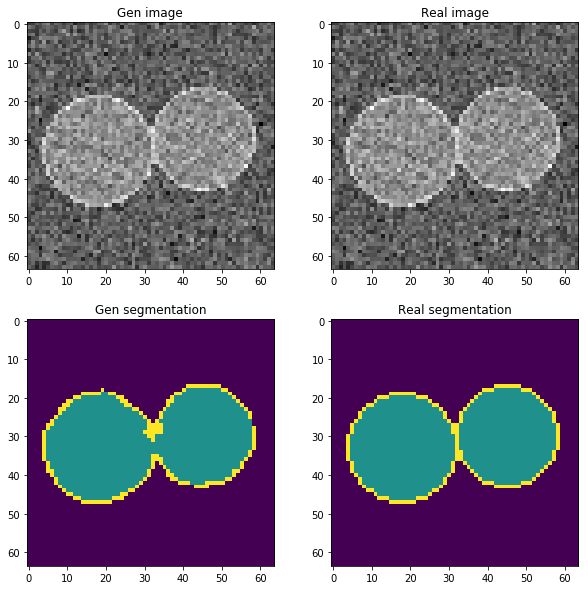

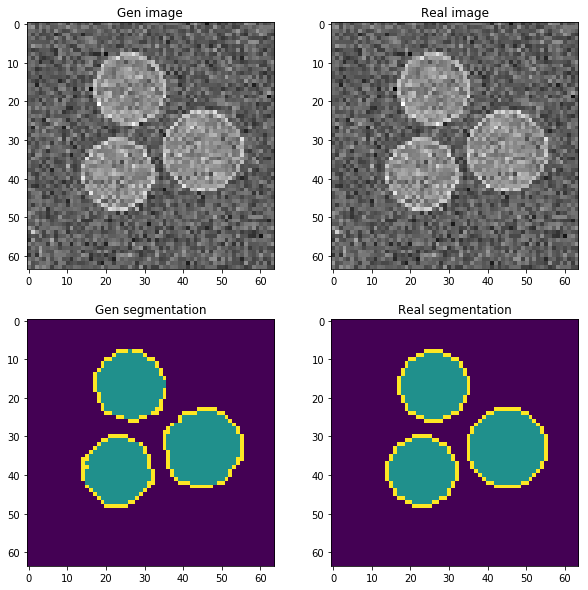

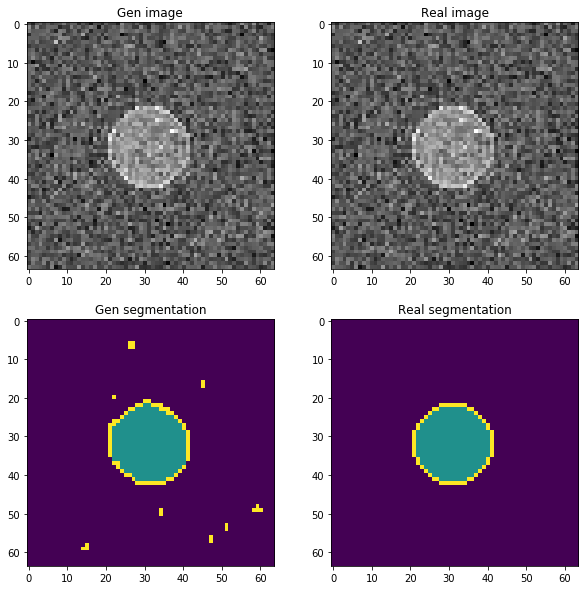

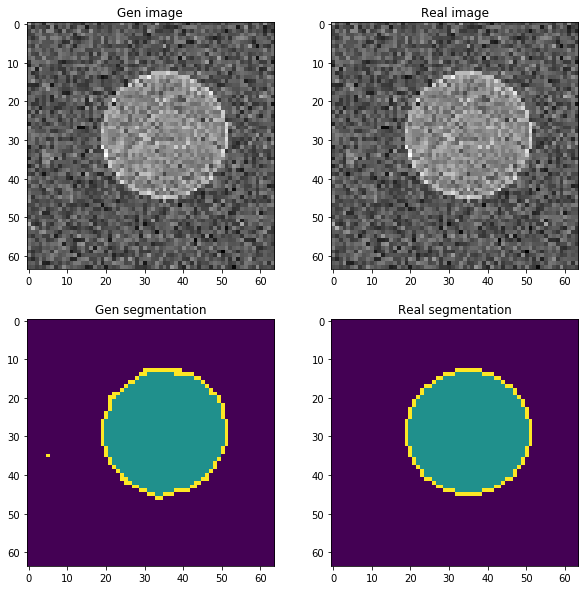

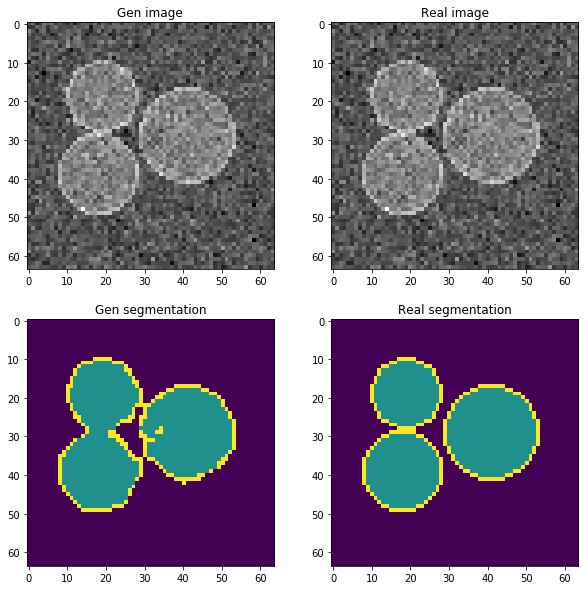

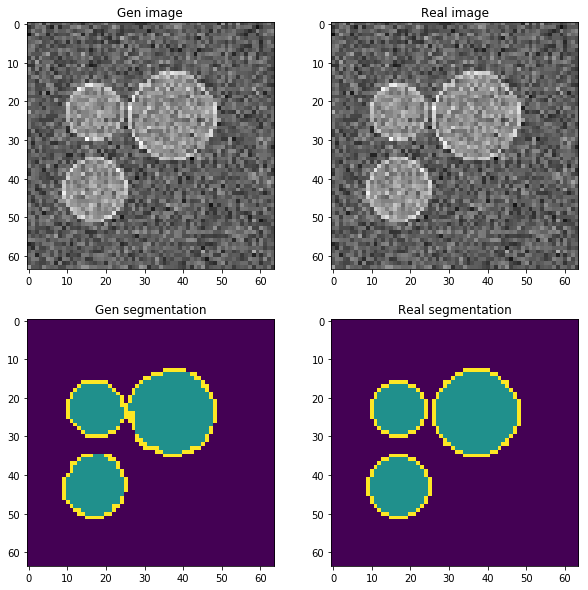

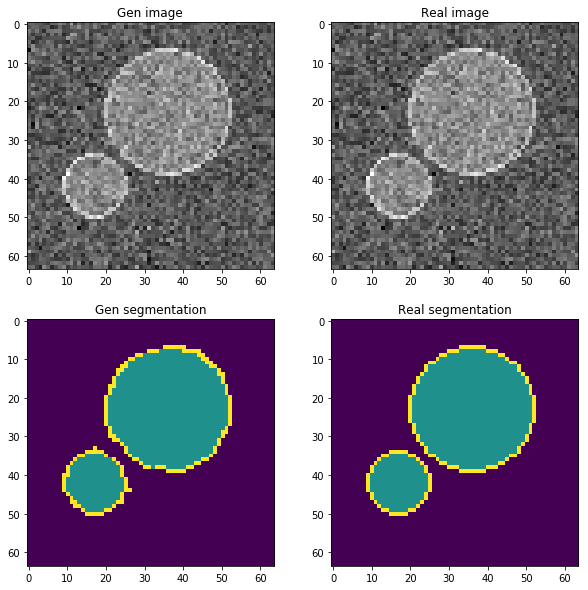

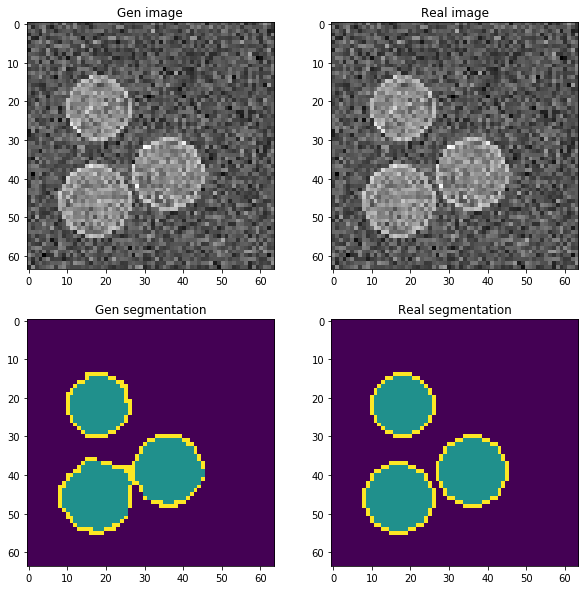

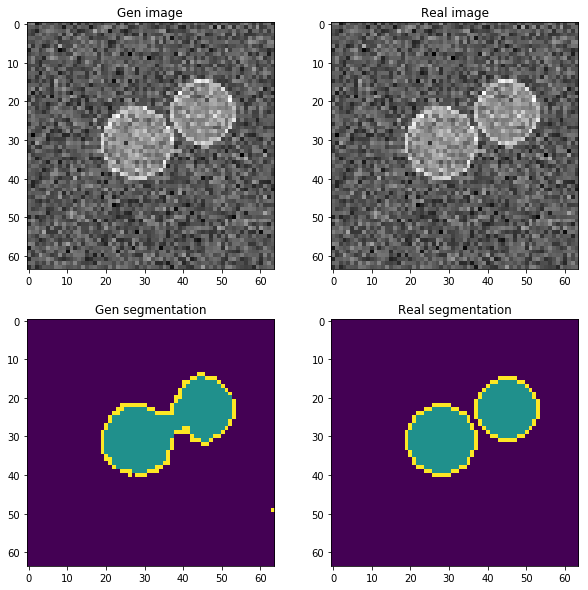

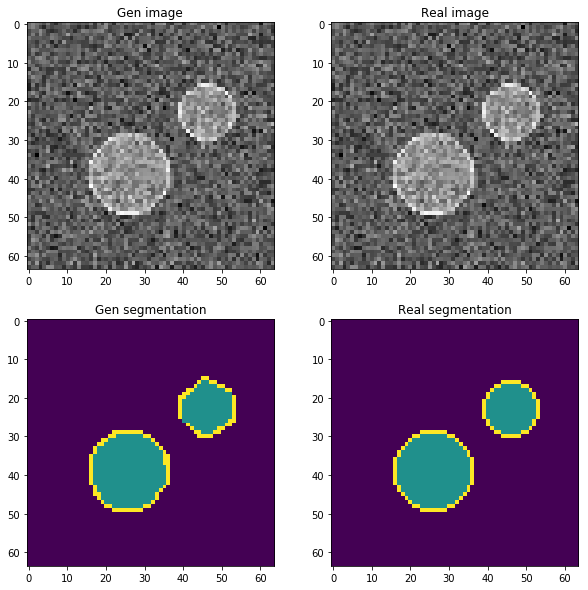

In [16]:
segmentation_value = test(net=net, test_images=test_images, test_segmentation=test_segmentation, 
                          segm_loss=segm_loss)

In [17]:
print('segmentation loss on baseline model = {}'.format(segmentation_value))

segmentation loss on baseline model = 0.173475086689


### train generative model with unlabelled data

In [13]:
net_gen = Unet(num_z_channels=3, num_classes=3, is_generative=True).cuda()
img_loss = ImageLoss()
segm_loss = SegmentationLoss()

In [14]:
loss_gen = train_generative_unet(net=net_gen, train_images=train_images, 
                                 train_segmentation=train_segmentation, 
                                 segm_loss=segm_loss, img_loss=img_loss, 
                                 without_segmentation=80, z_input=z_input,
                                 print_history=10001)

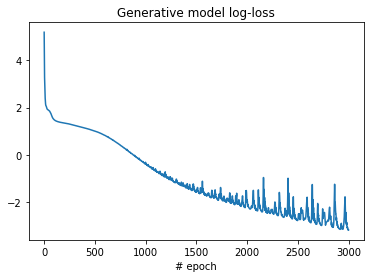

In [15]:
plt.plot(np.log(np.array(loss_gen)))
plt.title('Generative model log-loss')
plt.xlabel('# epoch')
plt.show()

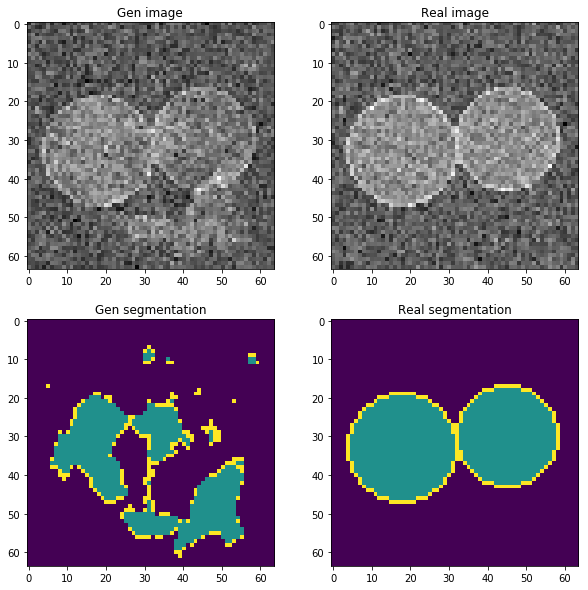

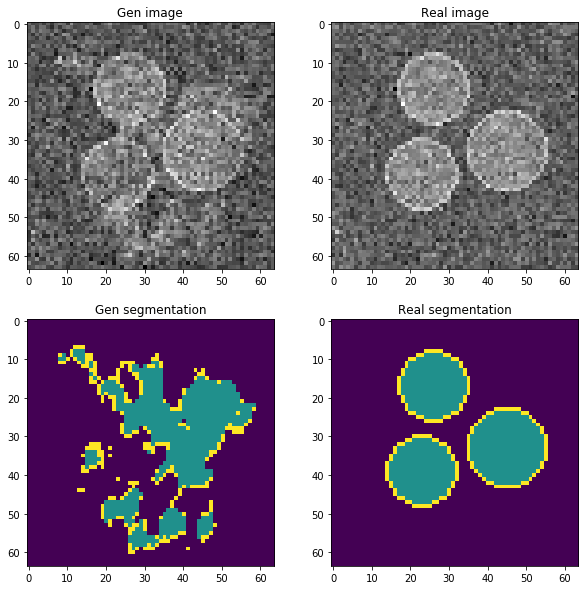

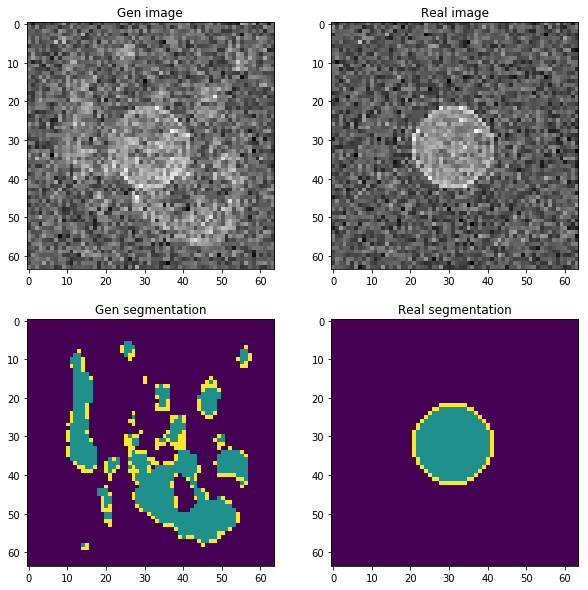

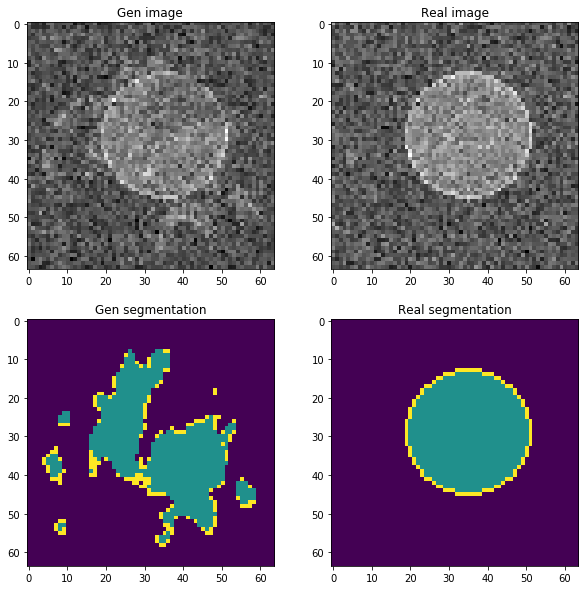

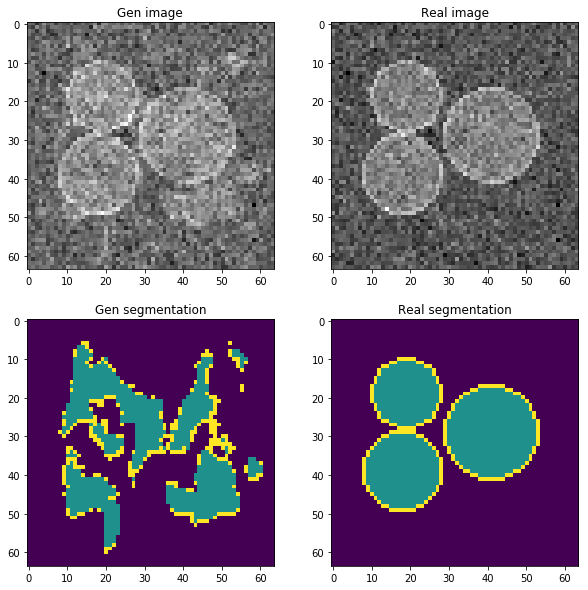

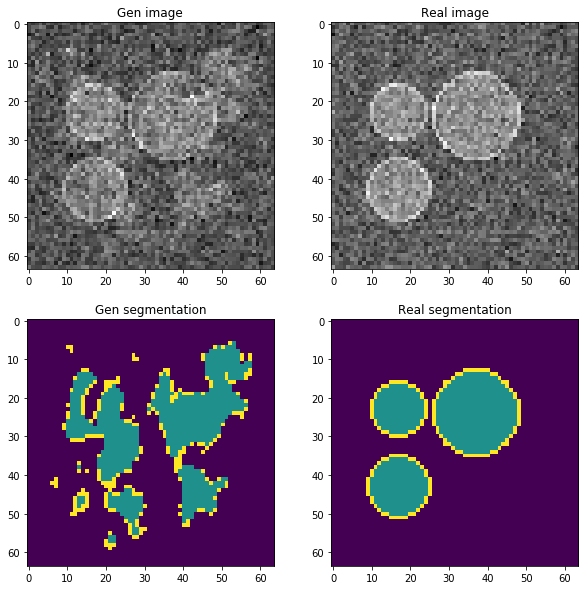

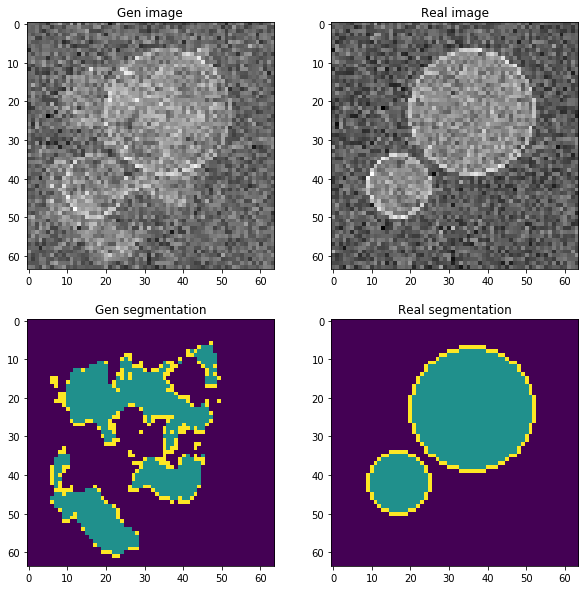

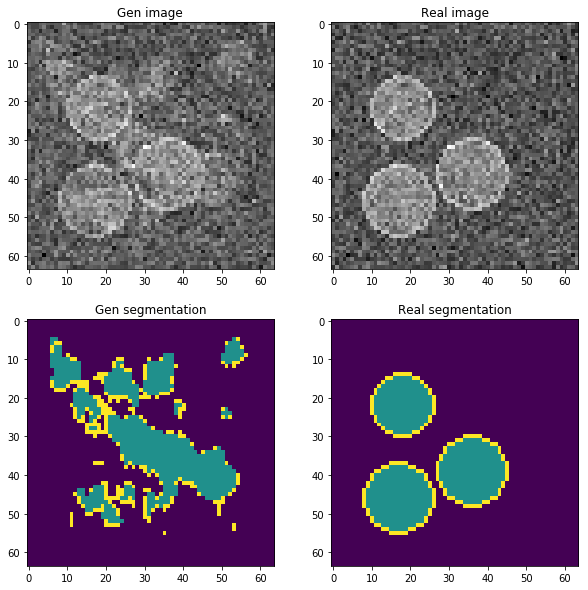

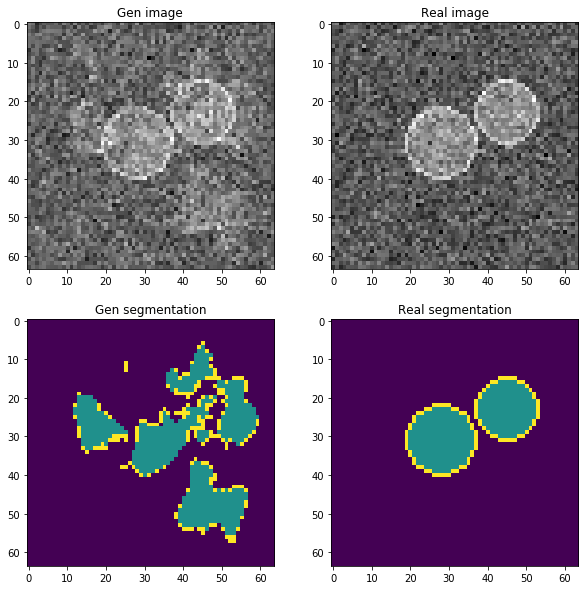

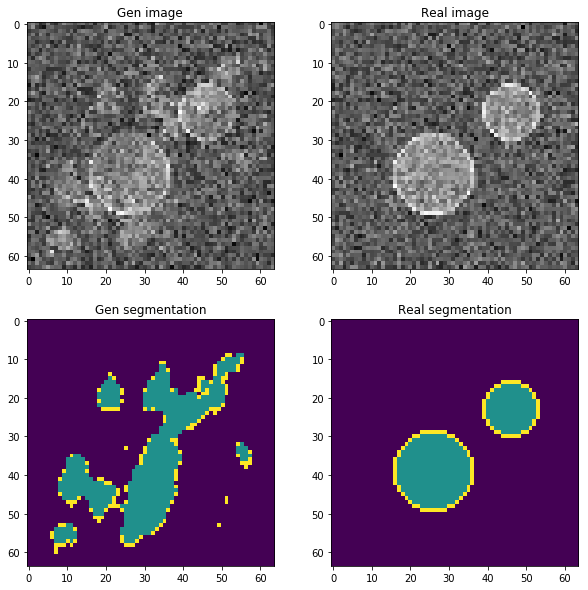

In [16]:
gen_loss, segm_loss = test(net=net_gen, 
                           test_images=test_images, 
                           test_segmentation=test_segmentation, 
                           segm_loss=segm_loss, 
                           img_loss=img_loss, 
                           is_generative=True, 
                           z_input=z_test, 
                           lr=0.005, 
                           num_epoch=200)

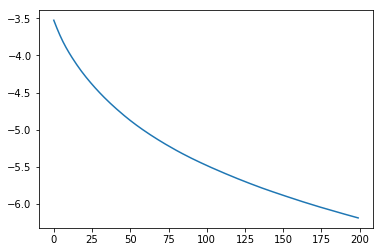

In [17]:
plt.plot(np.log(np.array(gen_loss)))
plt.show('image loss while optimizing on z latent variables')
plt.show()

In [18]:
print('segmentation loss on generative model = {}'.format(segm_loss))

segmentation loss on generative model = 1.88770961761


### simple model

In [15]:
net_gen = Network(num_z_channels=3, num_classes=3).cuda()
img_loss = ImageLoss()
segm_loss = SegmentationLoss()

In [16]:
loss_simple_gen = train_generative_unet(net=net_gen, train_images=train_images, 
                                        train_segmentation=train_segmentation, 
                                        segm_loss=segm_loss, img_loss=img_loss, 
                                        without_segmentation=80, z_input=z_input,
                                        print_history=10001)

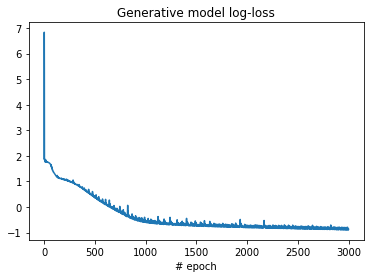

In [17]:
plt.plot(np.log(np.array(loss_simple_gen)))
plt.title('Generative model log-loss')
plt.xlabel('# epoch')
plt.show()

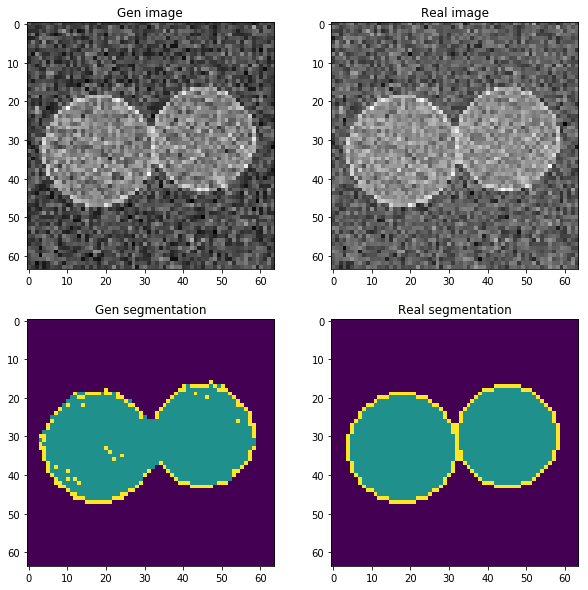

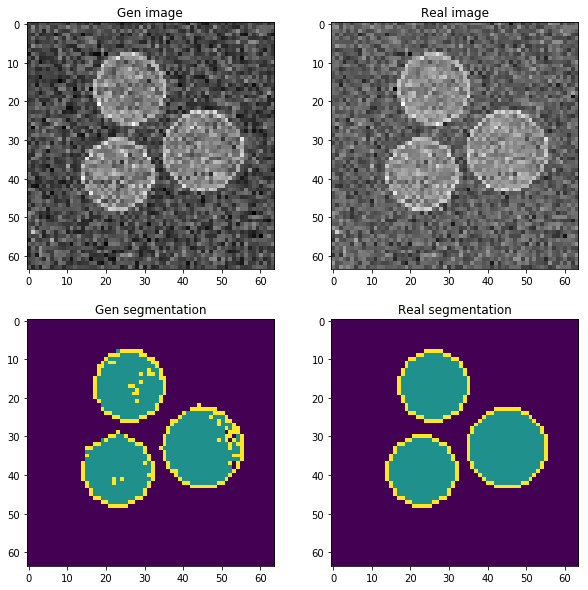

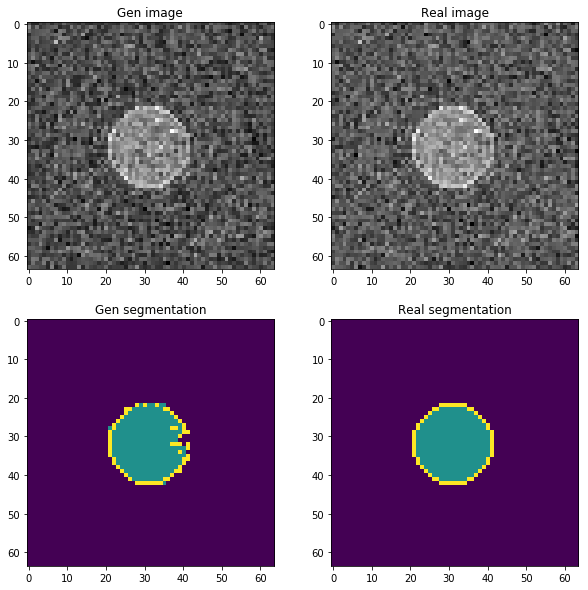

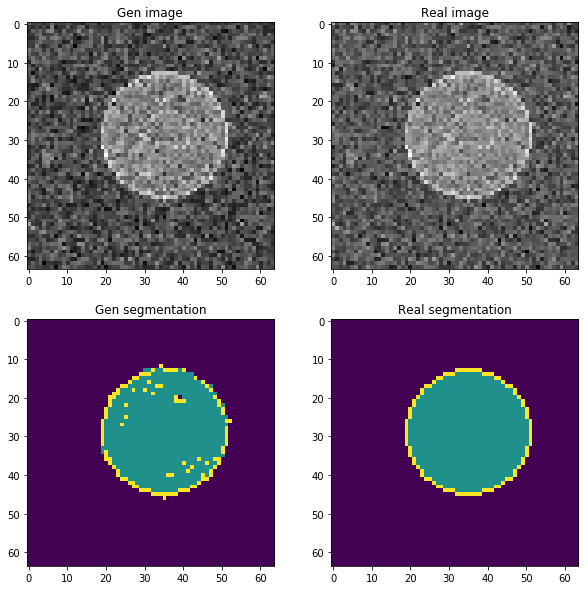

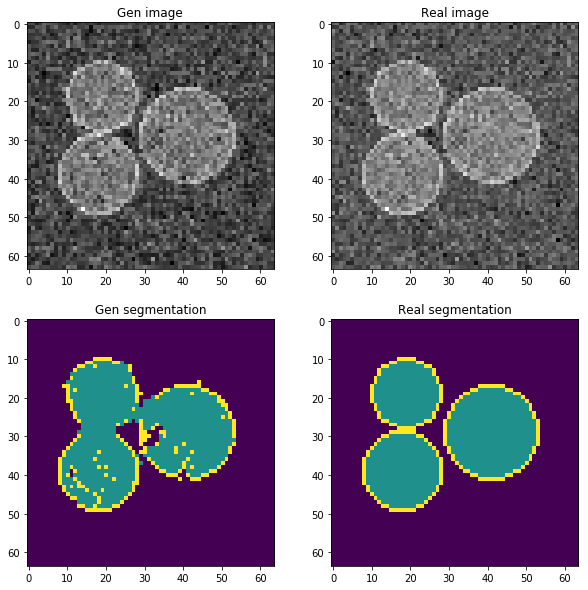

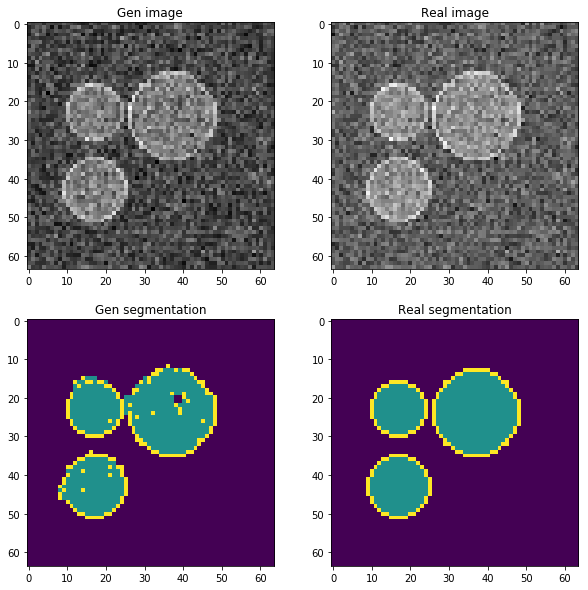

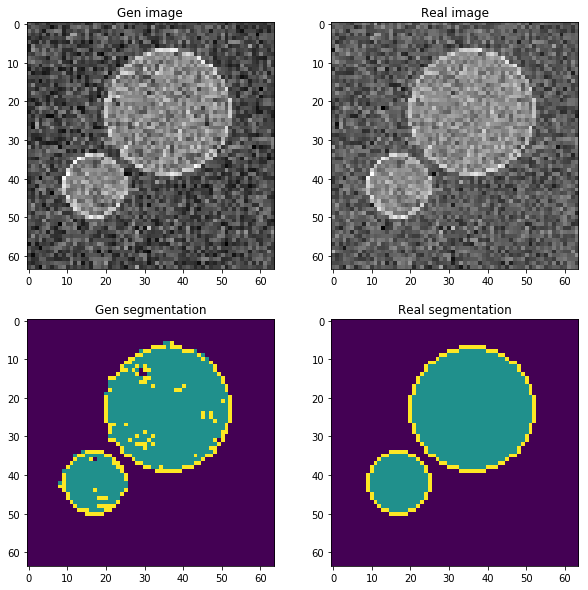

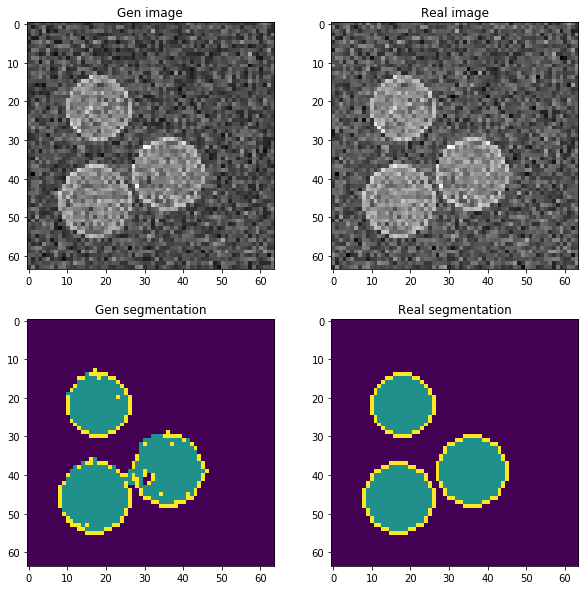

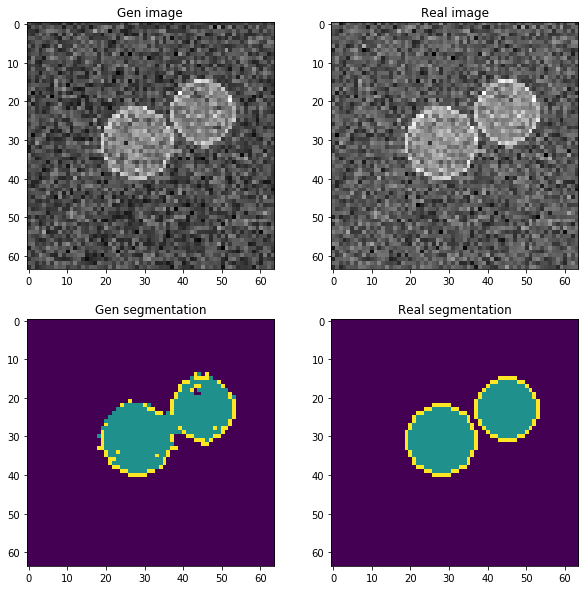

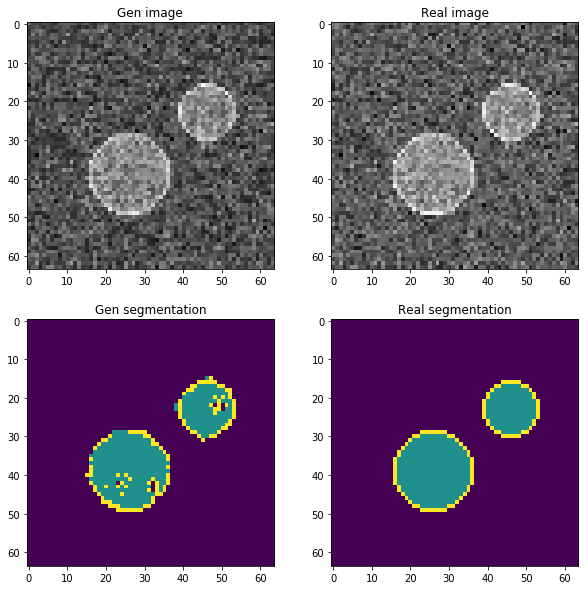

In [18]:
gen_loss, segm_loss = test(net=net_gen, 
                           test_images=test_images, 
                           test_segmentation=test_segmentation, 
                           segm_loss=segm_loss, 
                           img_loss=img_loss, 
                           is_generative=True, 
                           z_input=z_test, 
                           lr=0.005, 
                           num_epoch=200)

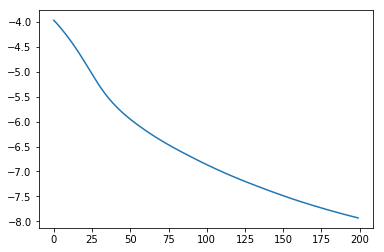

In [19]:
plt.plot(np.log(np.array(gen_loss)))
plt.show('image loss while optimizing on z latent variables')
plt.show()

In [20]:
print('segmentation loss on generative model = {}'.format(segm_loss))

segmentation loss on generative model = 0.0854977816343


### dcgan generator

In [22]:
dcgan = NetG(z_dim=512).cuda()
img_loss = ImageLoss()
segm_loss = SegmentationLoss()

In [23]:
dcgan_loss = train_generative_unet(net=dcgan, train_images=train_images, 
                                   train_segmentation=train_segmentation, 
                                   segm_loss=segm_loss, img_loss=img_loss, 
                                   without_segmentation=80, z_input=z_input, 
                                   print_history=500001, num_epochs=500000)

100%|██████████| 500000/500000 [26:02:51<00:00,  5.33it/s]   


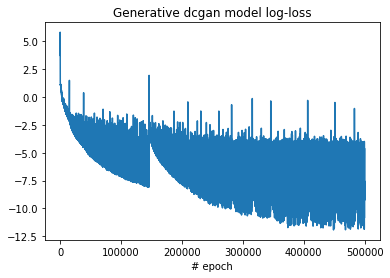

In [24]:
plt.plot(np.log(np.array(dcgan_loss)))
plt.title('Generative dcgan model log-loss')
plt.xlabel('# epoch')
plt.show()

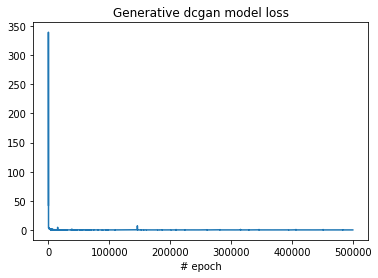

In [25]:
plt.plot(np.array(dcgan_loss))
plt.title('Generative dcgan model loss')
plt.xlabel('# epoch')
plt.show()

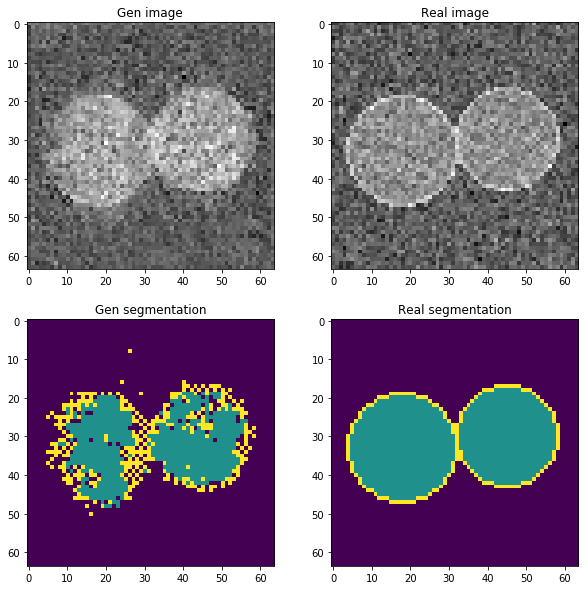

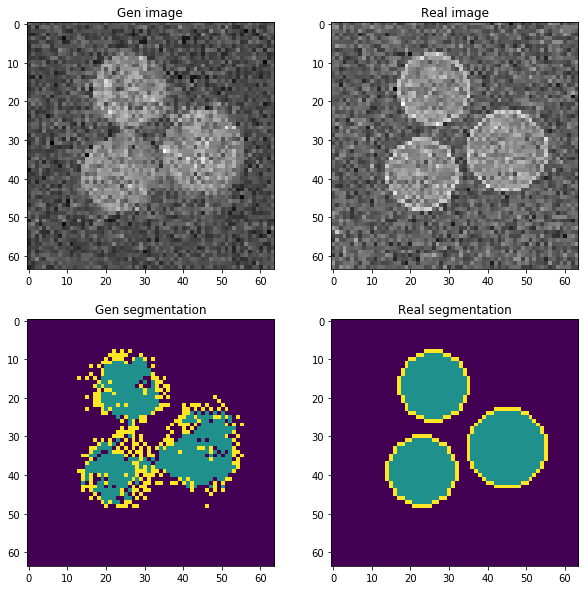

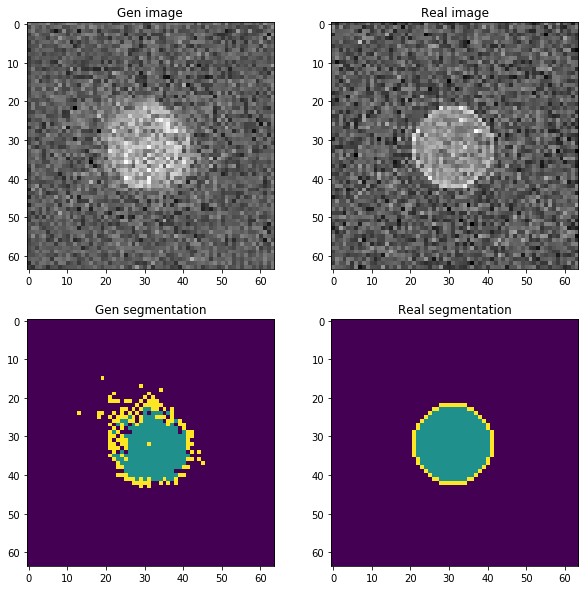

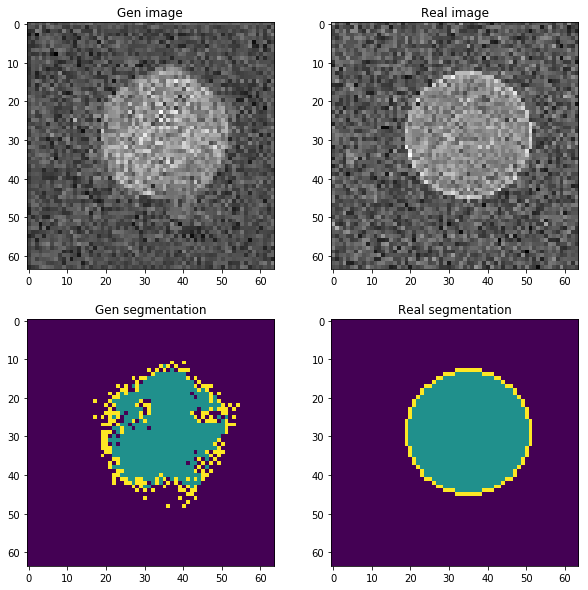

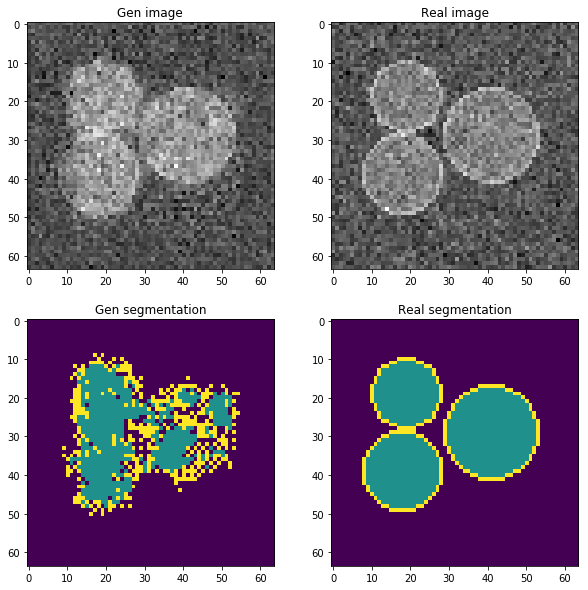

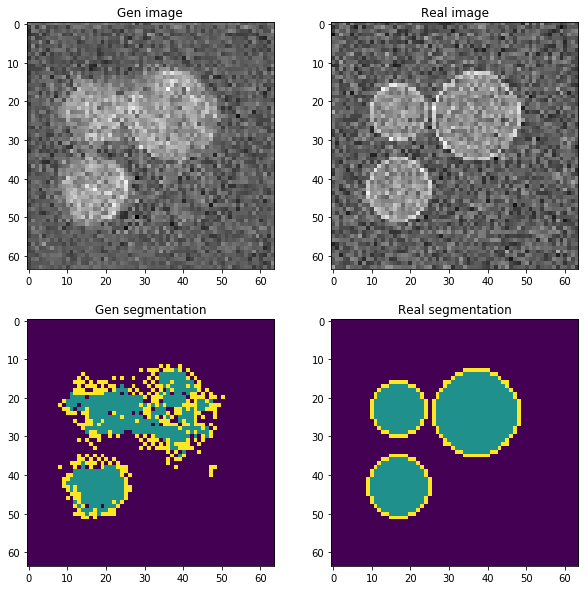

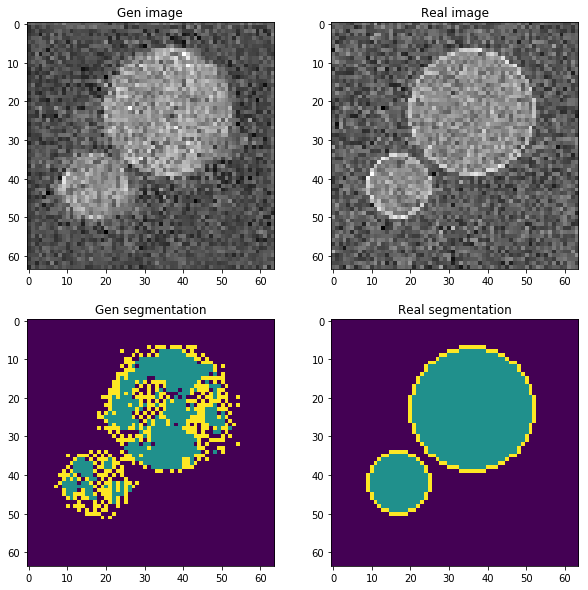

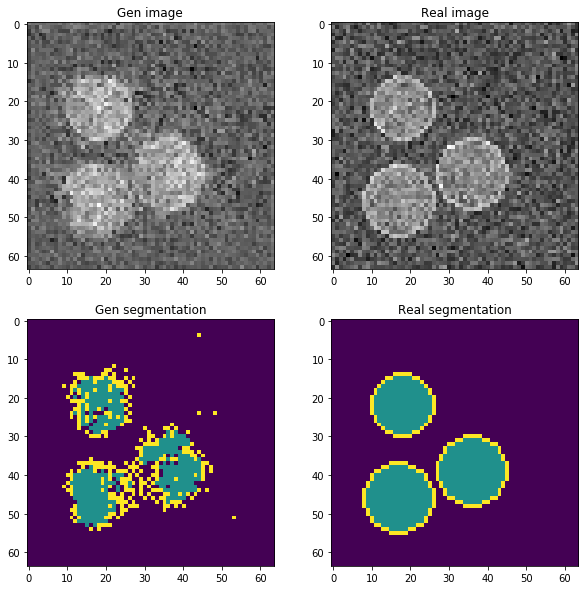

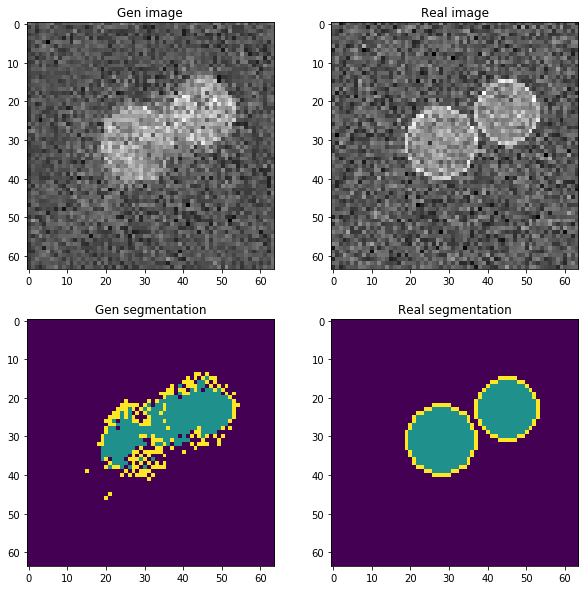

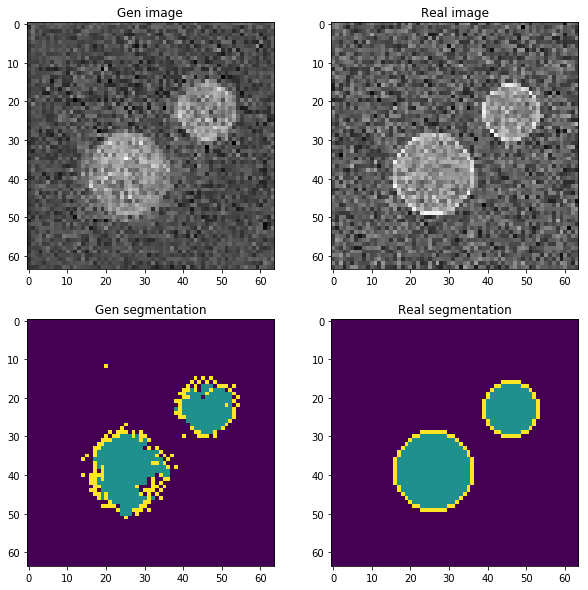

In [26]:
gen_loss, segm_loss = test(net=dcgan, 
                           test_images=test_images, 
                           test_segmentation=test_segmentation, 
                           segm_loss=segm_loss, 
                           img_loss=img_loss, 
                           is_generative=True, 
                           z_input=z_test, 
                           lr=0.005, 
                           num_epoch=50000)

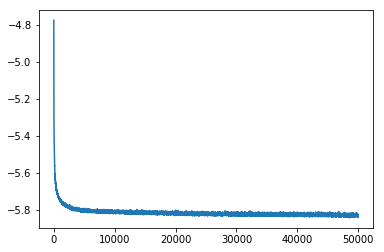

In [27]:
plt.plot(np.log(np.array(gen_loss)))
plt.show('image loss while optimizing on z latent variables')
plt.show()

In [28]:
print('segmentation loss on generative model = {}'.format(segm_loss))

segmentation loss on generative model = 1.7103646993637085
